Stress test:
- There are 5531452 rows in the csv file in total (including header)
- It takes 3m31s to read train_data.csv

In [1]:
# N = sum(1 for line in open('data/train_data.csv'))
# N
# print(sum(1 for line in open('data/train_labels.csv')))

In [2]:
# df = pd.read_csv('data/train_data.csv')
# labels = pd.read_csv('data/train_labels.csv')

## Setup

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
features = pd.read_csv('data/train_data.csv')
labels = pd.read_csv('data/train_labels.csv')

d:\Users\jason\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Categorize columns by type: 

In [4]:
features.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [5]:
obj_cols = features.select_dtypes(include=['O']).columns
obj_cols

Index(['customer_ID', 'S_2', 'D_63', 'D_64'], dtype='object')

In [6]:
int_cols = features.select_dtypes(include=['int64']).columns
int_cols

Index(['B_31'], dtype='object')

In [7]:
print('B_31', features.B_31.unique())
for col in obj_cols.drop(['customer_ID', 'S_2']): # S_2 is a date
    print(col, features[col].unique())

B_31 [1 0]
D_63 ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 ['O' 'R' nan 'U' '-1']


In [8]:
float_cols = features.select_dtypes(include=['float64']).columns
float_cols

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=185)

In [9]:
nullcols = []
for col in features:
    if features[col].isnull().values.any():
        nullcols.append(col)
len(nullcols)

122

#### Generate distribution histograms of the columns:

In [10]:
###
# features.hist(bins=20, figsize=(60, 40))
###

## Preprocessing

#### Useful utility functions:

In [11]:
def get_sample(size):
    prng = np.random.RandomState(0)
    g = features.groupby('customer_ID')

    portion = features[g.ngroup().isin(prng.choice(g.ngroups, size, replace=False))]
    return portion

sample1 = get_sample(len(labels)//100)
# sample2 = get_sample(1000)

In [12]:
def get_y(ids):
    label_lookup = dict()
    for id in ids:
        if id not in label_lookup:
            target = labels.loc[labels.customer_ID == id, 'target']
            label_lookup[id] = target.iloc[0]

    return pd.Series([label_lookup[id] for id in ids], index=ids)
    # for id in features.customer_ID.unique():
    #     if len(features.loc[features.customer_ID == id, 'target'].unique()) != 1:
    #         print(features.loc[features.customer_ID == id])
    
# sample2y = get_y(sample2['customer_ID'])
# sample2y

In [13]:
###
# from sklearn.impute import SimpleImputer
# sample2copy = sample2.copy()
# sample2copy.index = sample2copy['customer_ID']
# fitted_imputers = sample2copy.groupby(sample2copy.index).apply(lambda df: SimpleImputer(strategy='most_frequent').fit(df[['D_64', 'D_63']]))
# fitted_imputers = {fitted_imputers.index[i] : fitted_imputers.iloc[i] for i in range(len(fitted_imputers))}

# transformed = sample2copy.groupby(sample2copy.index).apply(
#     lambda df: pd.DataFrame(
#         fitted_imputers[df.index[0]].transform(df[['D_64', 'D_63']]), 
#     ))
# transformed.reset_index()
# transformed.index = sample2copy.index
# pd.DataFrame(transformed)
# # type(fitted_imputers)

# # imputer = SimpleImputer(strategy='most_frequent').fit(sample2copy[['D_64']])
# # transformed_column = imputer.transform(sample2copy[['D_64']])
# # transformed_column
###

#### Potential Pipeline:
- Apply OHE/MEstimate
- Combine IDs
- Impute missing values
- (PCA)
- (KMeans)
- Train
- Predict
- Cross validate

#### Data Imputation:

In [14]:
from lib2to3.pytree import Base
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import Column

class ByIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cnames = None):
        self.cnames = cnames
        self.transformer = transformer
    def fit(self, X: pd.DataFrame, y = None):
        self.fitted_transformers = X.groupby(X.index).apply(
            lambda df: self.transformer.fit(df if self.cnames == None else df[self.cnames]))
        self.fitted_transformers = {self.fitted_transformers.index[i] : self.fitted_transformers.iloc[i] for i in range(len(self.fitted_transformers))}
        return self
    def transform(self, X: pd.DataFrame, y = None):
        transformed = X.groupby(X.index).apply(
            lambda df: pd.DataFrame(
                self.fitted_transformers[df.index[0]]
                .transform(df if self.cnames == None else df[self.cnames])
            )
        )
        transformed.reset_index()
        transformed.index = X.index
        return transformed

class IDFoldTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, id_name = None):
        self.id_name = id_name
    def fit(self, X: pd.DataFrame, y = None):
        return self
    def transform(self, X: pd.DataFrame, y = None):
        return X.groupby(X.index if self.id_name == None else self.id_name).apply(lambda df: df.mean()).unstack().reset_index()
        
###
# class DFTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, cnames)

# # class EncoderWrapper(BaseEstimator, TransformerMixin):
# #     def __init__(self, encoder):
# #         self.encoder = encoder
# #     def fit(self, X: np.ndarray, y = None):
# #         self.encoder.fit(X, y)
# #         return self
# #     def transform(self, X: np.ndarray, y = None):
# #         encoded_cols = self.encoder.transform(X)
# #         encoded_df = pd.DataFrame(encoded_cols)
# #         return encoded_df

# def column_types(features: pd.DataFrame):
#     categoricals = []
#     objects = []
#     numericals = []
#     for cname in features.columns:
#         col = features[cname]
#         if col.dtype == 'object':
#             if col.nunique() < 10:
#                 categoricals.append(cname)
#             else:
#                 objects.append(cname)
#         elif col.dtype in ['int64', 'float64']:
#             numericals.append(cname)
#         else:
#             print(f"{cname}: no column category matched")
#     return categoricals, numericals, objects

# def preprocess(features: pd.DataFrame, y = None):
#     categoricals, numericals, objects = column_types(features)
    
#     # Preprocesses categoricals
#     onehot = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
#     ])
#     transformers = ColumnTransformer(transformers=[
#         ('cat', onehot, categoricals)
#     ], remainder='passthrough')
    
#     encoded_cols = transformers.fit_transform(features)
#     df = pd.DataFrame(encoded_cols)
#     print(encoded_cols)

#     df = df.groupby('customer_ID').apply(lambda df: df.mean()).unstack().reset_index()

#     return df

# # X = sample2.drop('D_64', axis=1)
# # X = preprocess(X)
# # X.head()
###

d:\Users\jason\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
d:\Users\jason\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
d:\Users\jason\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [16]:
def impute_X_bygroup(data):
    X = data.copy().drop('S_2', axis=1)
    X.index = X.customer_ID
    for cname in X.select_dtypes(["object"]).drop('customer_ID', axis=1):
        X[cname], _ = X[cname].factorize()

    discretes = (X.dtypes == 'int64').drop('customer_ID')
    d, n = [], []
    for cname in X.columns:
        if cname == 'customer_ID':
            continue
        if X[cname].dtype == 'int64':
            d.append(cname)
        else:
            n.append(cname)

    default_col_values = {cname: X[cname].mean() for cname in n}
    def process_group(col_defaults: dict, df: pd.DataFrame):
        for cname in df.columns:
            if df[cname].isna().all():
                df[cname].fillna(col_defaults[cname], inplace=True)
        return df

    X_processed = X.groupby(X.index).apply(lambda df: process_group(default_col_values, df))

    num_t = ByIndexTransformer(SimpleImputer(verbose=100), n)
    nums = num_t.fit_transform(X_processed)
    nums.columns = n

    imputed = nums.copy()
    imputed[d] = X[d]
    return imputed, discretes

imputed, discretes = impute_X_bygroup(sample1)

#### Mutual Information:

relatively informative: 

In [17]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discretes):
    mi_scores = mutual_info_classif(X, y, discrete_features=discretes)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

imputed_y = get_y(imputed.index)
mi_scores = make_mi_scores(imputed, imputed_y, discretes)
mi_scores.head(5)

B_32    0.571671
B_16    0.571671
D_65    0.571671
D_77    0.226626
P_2     0.212452
Name: MI Scores, dtype: float64

relatively uninformative:

In [66]:
mi_scores.tail(5)

R_23     0.0
S_18     0.0
D_109    0.0
D_96     0.0
R_18     0.0
Name: MI Scores, dtype: float64

discrete features:

In [19]:
mi_scores.loc[discretes]

D_64    0.022344
B_31    0.010520
D_63    0.004730
Name: MI Scores, dtype: float64

There are some commonalities among the distribution of the continuous columns with low MI:
- Singular-value groups (like B_6)
- Binary groups (like B_8)

There are also some continuous columns with unusual distributions:
- Discrete groups (D_68)

Below, binary grouped and singular-value grouped items are separated:

In [39]:
from mlxtend.preprocessing import minmax_scaling
def get_binary_cols(features):
    scaled_data = minmax_scaling(features.drop(obj_cols, axis=1), columns=features.drop(obj_cols, axis=1).columns)
    binary_cols = []
    for cname in scaled_data:
        cmean = scaled_data[cname].mean()
        if len(scaled_data.loc[(0.01 < scaled_data[cname]) & (scaled_data[cname] < 0.99)]) == 0:
            binary_cols.append(cname)
    return binary_cols

binary_cols = get_binary_cols(sample1)
print(binary_cols[:10], len(binary_cols))

['R_2', 'S_6', 'R_4', 'D_66', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19'] 34


#### Principal Components: 

In [41]:
from sklearn.decomposition import PCA

def make_pca(pca_features):
    pca_scaled = (pca_features - pca_features.mean(axis=0)) / pca_features.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(pca_features)

    column_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = column_names)

    return pca, X_pca

floats = (imputed.dtypes == 'float64').drop(binary_cols)
pca_cnames = floats.loc[floats == True].index
# pca_cnames = ['B_16', 'B_32', 'D_65', 'D_77', 'P_2']
pca_features = imputed.loc[:, pca_cnames]
pca, X_pca = make_pca(pca_features)

Binary grouped float features are dropped because they can be better represented as non-continuous features

In [42]:
pca_mi = make_mi_scores(X_pca, imputed_y, False)
pca_mi.head(5)

PC2     0.163159
PC5     0.153685
PC3     0.153383
PC1     0.128207
PC7     0.121625
PC10    0.116315
PC8     0.113749
PC4     0.112370
PC6     0.101312
PC12    0.095533
Name: MI Scores, dtype: float64

Above indicates that the principal component axes are not as informative as the features themselves, which might be because there isn't a lot of correlation among the individual features

In [62]:
# a useful baseline for looking at PCA component values
baseline = 1/152
baseline

0.006578947368421052

In [43]:
components = pd.DataFrame(pca.components_.T, columns = X_pca.columns, index = pca_features.columns)
components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152
P_2,0.000295,-0.004887,-0.012864,0.027227,-0.019747,-0.009851,0.070927,0.003397,-0.031168,-0.041861,-0.091696,0.112433,0.016760,-0.084835,-0.010300,-0.036774,0.027740,0.021256,0.048350,0.022265,-0.031329,-0.051422,-0.047906,-0.022049,-0.003490,0.028581,-0.032000,-0.067007,-0.055038,0.065922,0.024849,-0.012937,0.063947,-0.070388,0.080195,0.061626,-0.007365,-0.002172,0.025364,-0.019103,...,-0.188191,0.057404,-0.069671,0.029530,-0.069064,-0.049272,-0.008461,-0.001095,0.010849,-0.160433,-0.041096,-0.018508,-0.023761,0.025046,-0.005560,0.000286,0.001381,-0.008425,0.024204,-0.008582,-0.001035,0.010272,-0.001516,0.001516,0.001777,0.002890,0.000122,-0.000490,0.000670,0.001474,-0.001525,-0.002718,0.000477,-0.000895,-0.001265,0.000117,0.000109,-0.000129,-0.000171,-0.000081
D_39,-0.000199,0.001496,0.005310,-0.003329,0.015247,0.021501,-0.026349,0.000720,-0.006813,-0.049596,0.016393,-0.027560,0.065259,0.070087,-0.013636,0.009220,-0.028987,-0.026906,0.011823,-0.027130,-0.057155,0.123245,0.194660,-0.012381,0.013279,0.028242,0.034347,-0.030104,-0.034745,-0.076635,0.038648,0.006841,0.069694,0.023748,0.045173,0.065526,0.084474,0.088566,0.052905,0.066013,...,0.007731,-0.002961,0.002267,0.008025,0.007782,-0.014123,0.010029,-0.000632,0.005516,0.002188,0.001265,0.004204,-0.000830,0.010684,0.000623,-0.001936,-0.000096,-0.001510,-0.002250,0.003309,-0.001782,0.000439,0.001407,-0.000344,0.000835,0.001654,-0.000145,-0.000505,0.001483,-0.000073,-0.002915,0.002112,-0.001276,-0.002162,0.000165,0.000021,0.000064,-0.000106,0.000038,0.000057
B_1,-0.000286,0.000969,0.008744,-0.014930,0.012747,0.008637,-0.071201,-0.015635,-0.015002,0.001317,0.029906,-0.001517,0.024911,-0.004906,-0.077434,0.081123,0.033745,0.048788,0.065135,-0.111360,-0.117951,-0.077325,-0.009318,-0.009367,0.005597,0.057038,0.011943,-0.014605,-0.019750,-0.113904,0.051852,0.054219,0.053862,-0.037553,0.039909,-0.075093,-0.045635,0.005998,-0.047005,0.025455,...,-0.013022,0.022994,0.005665,-0.013589,-0.007291,-0.001337,-0.019712,-0.008148,-0.007220,0.015396,0.000897,-0.006016,0.001221,0.012001,-0.003368,-0.000340,-0.000303,0.005045,-0.013781,0.002633,-0.000780,0.005778,0.231124,-0.065648,0.004517,0.100435,-0.005894,-0.008321,0.019720,0.003328,0.076083,-0.041102,0.421248,0.643400,-0.001076,0.002113,-0.000614,-0.000723,0.001325,-0.000828
B_2,0.000746,-0.003192,-0.019976,0.039450,-0.032465,-0.026834,0.153364,0.032297,0.023014,-0.059900,-0.074171,0.076612,-0.015350,0.016738,0.127861,-0.106682,-0.039897,-0.072182,-0.073069,0.135670,0.120382,-0.018216,-0.053460,-0.000185,-0.065972,0.109213,0.032490,-0.057352,0.049096,-0.178227,0.070198,0.075445,-0.076048,-0.028858,0.021344,-0.206725,-0.105947,-0.050841,0.059896,0.024334,...,-0.141614,-0.057441,-0.011691,-0.003254,-0.000309,-0.014400,-0.030550,0.030289,0.002922,0.009598,0.009808,-0.012429,-0.057247,-0.074349,-0.038490,0.008781,-0.018061,0.005023,-0.013977,0.015566,0.000504,-0.001091,-0.014215,0.003966,-0.003424,-0.002258,-0.001948,-0.008583,-0.027575,0.000384,0.007917,-0.003903,0.000410,0.005420,0.000170,0.000666,0.000043,-0.000074,-0.000036,-0.000030
R_1,-0.000185,0.006360,0.004458,-0.013128,0.010407,0.007108,-0.042049,0.023508,0.008708,0.019778,0.111135,-0.041903,0.046521,0.115927,0.009878,-0.047513,-0.085897,-0.018282,-0.011719,-0.001516,0.002163,-0.004221,0.039521,-0.096232,0.016162,0.153253,-0.063016,0.070847,-0.023647,0.050327,-0.015261,-0.013402,-0.037619,-0.092048,0.063766,0.003221,0.008726,-0.006375,-0.037421,0.003737,...,-0.036832,-0.013343,-0.002080,0.011178,-0.001140,-0.017449,0.002825,0.009642,-0.004587,0.006620,0.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020528363F28>,
      dtype=object)

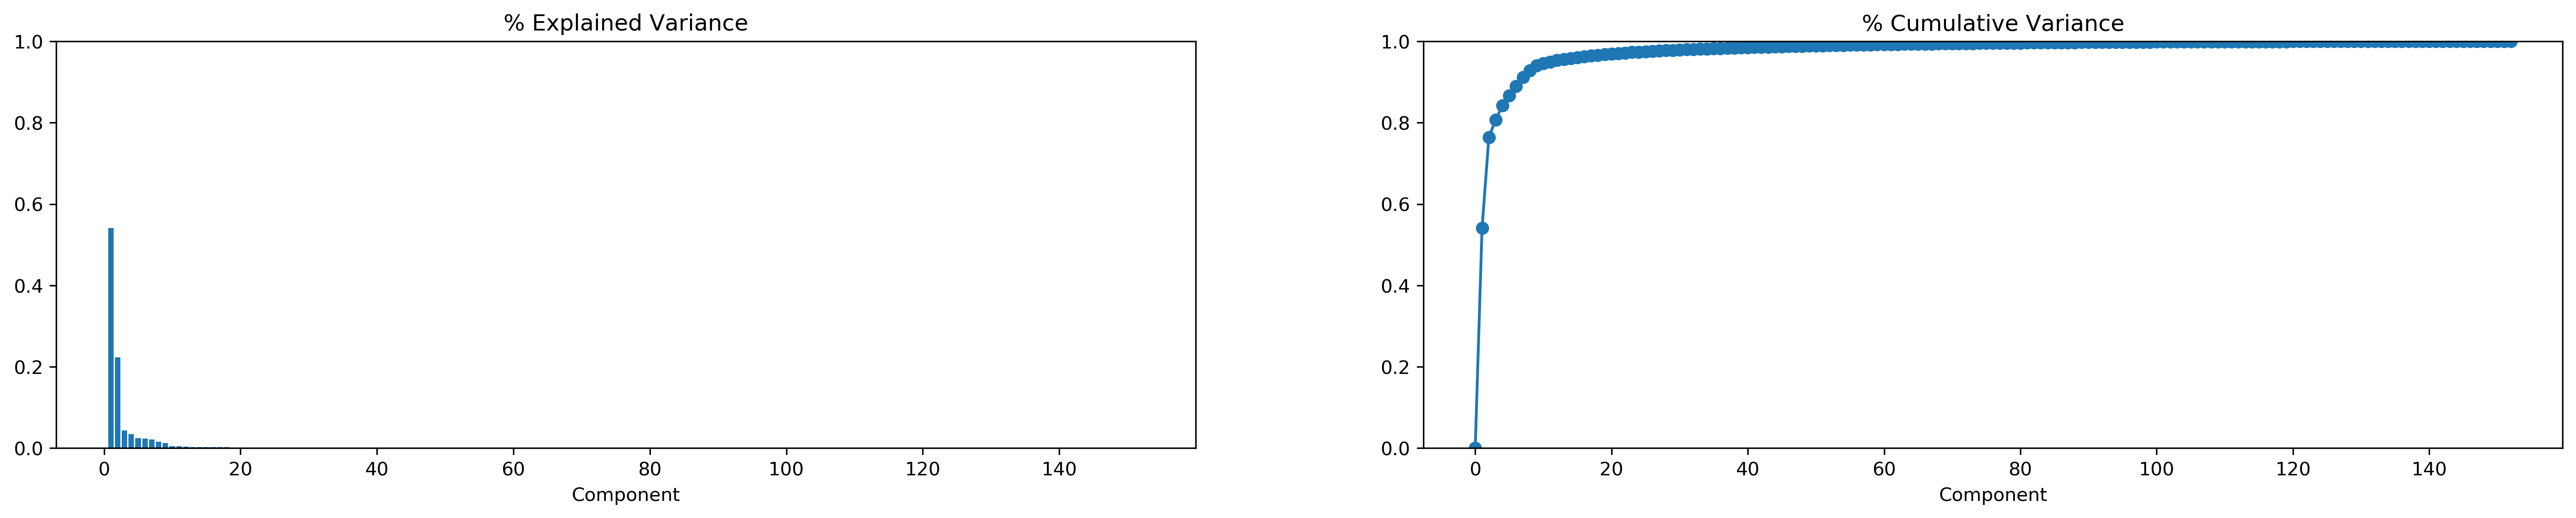

In [53]:
import matplotlib.pyplot as plt

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

plot_variance(pca, 24, 300)

Check if features with low MI contain information that features with high MI can't explain

In [87]:
pca_low_mi = (components.loc[(components.index.isin(mi_scores.tail(20).index))]).T
pca_low_mi.head()

,B_15,S_12,D_80,B_27,S_17,R_18,S_19,B_36,B_42
PC1,-0.000046,0.000310,-0.000169,1.000583e-06,0.000106,-0.000001,1.603367e-06,1.304193e-07,4.536378e-07
PC2,-0.000140,0.000113,-0.000245,-6.142221e-07,0.000105,-0.000001,-4.479839e-07,-1.321724e-05,1.152996e-07
PC3,-0.000037,-0.000443,0.000794,-1.730367e-06,0.000334,0.000003,-1.207716e-06,2.823946e-05,-2.554183e-05
PC4,0.003563,0.000852,-0.002467,-3.688423e-06,-0.001082,-0.000002,-1.123578e-05,-1.662648e-05,3.472463e-04
PC5,0.013899,0.000292,0.005104,1.077237e-04,0.002138,-0.000005,-1.607433e-06,4.131847e-05,-4.530767e-05


In [88]:
for cname in pca_low_mi.columns:
    temp = []
    for i in range(len(pca_low_mi)):
        if abs(pca_low_mi[cname].iloc[i]) > 0.1:
            temp.append(pca_low_mi.index[i])
    print(f'{cname} : {temp}')

B_15 : ['PC13', 'PC16', 'PC26', 'PC30', 'PC41', 'PC50', 'PC52', 'PC53', 'PC56', 'PC57', 'PC58', 'PC65', 'PC66', 'PC71', 'PC73', 'PC75', 'PC82', 'PC83', 'PC84', 'PC105', 'PC126', 'PC148']
S_12 : ['PC45', 'PC54', 'PC55', 'PC57', 'PC58', 'PC60', 'PC61']
D_80 : ['PC33', 'PC35', 'PC51', 'PC52', 'PC57', 'PC58', 'PC59', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65', 'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC74', 'PC75', 'PC81', 'PC82', 'PC83', 'PC97']
B_27 : ['PC149', 'PC150', 'PC151', 'PC152']
S_17 : ['PC35', 'PC39', 'PC41', 'PC42', 'PC43', 'PC45', 'PC46', 'PC47', 'PC50', 'PC54', 'PC55', 'PC60']
R_18 : ['PC150', 'PC151']
S_19 : ['PC149', 'PC151']
B_36 : ['PC135', 'PC136', 'PC138', 'PC140', 'PC141', 'PC143', 'PC144', 'PC145']
B_42 : ['PC139']


The above indicates that the non-binary features with low MI scores generally don't have much variation that's unexplained by those with high MI scores, so it's probably safe to drop a few of them

Check for features with strong correlations with each other:

In [67]:
selected_components = components[[f'PC{i}' for i in range(1, 51)]]
corr_df = pd.DataFrame()
for cname in selected_components.columns:
    temp = []
    for i in range(len(selected_components)):
        val = selected_components[cname].iloc[i]
        if -baseline > val or baseline < val:
            temp.append(val)
        else:
            temp.append(pd.NA)
    corr_df[cname] = temp

corr_df.columns = selected_components.columns
corr_df.index = selected_components.index
corr_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
P_2,<NA>,<NA>,-0.0128641,0.0272273,-0.0197472,-0.00985099,0.0709266,<NA>,-0.0311677,-0.041861,-0.0916963,0.112433,0.0167601,-0.0848353,-0.0103003,-0.036774,0.0277402,0.0212558,0.0483499,0.0222652,-0.0313288,-0.0514216,-0.0479064,-0.0220491,<NA>,0.0285806,-0.0319999,-0.0670068,-0.0550376,0.0659219,0.0248491,-0.0129368,0.0639474,-0.0703876,0.0801953,0.0616257,-0.00736534,<NA>,0.025364,-0.0191029,0.0595715,<NA>,0.0416243,0.00912173,-0.0201267,-0.033742,-0.0176883,-0.0239951,<NA>,-0.0122756
D_39,<NA>,<NA>,<NA>,<NA>,0.0152465,0.0215014,-0.0263489,<NA>,-0.00681256,-0.0495959,0.0163933,-0.0275604,0.065259,0.0700875,-0.0136358,0.0092198,-0.0289872,-0.0269056,0.011823,-0.0271297,-0.0571552,0.123245,0.19466,-0.0123806,0.0132789,0.0282418,0.0343473,-0.0301041,-0.0347447,-0.0766347,0.0386484,0.00684069,0.0696943,0.0237476,0.0451727,0.0655257,0.0844739,0.0885663,0.0529054,0.0660131,0.220466,-0.0333255,0.0203832,0.030468,-0.0773039,-0.0677534,-0.0417335,-0.0207148,-0.151257,-0.154175
B_1,<NA>,<NA>,0.0087438,-0.0149297,0.0127472,0.0086371,-0.0712013,-0.0156347,-0.0150018,<NA>,0.029906,<NA>,0.0249107,<NA>,-0.0774336,0.0811228,0.0337454,0.048788,0.0651352,-0.11136,-0.117951,-0.0773247,-0.00931799,-0.00936675,<NA>,0.0570385,0.0119429,-0.0146048,-0.0197502,-0.113904,0.0518517,0.0542193,0.053862,-0.0375531,0.0399092,-0.0750928,-0.045635,<NA>,-0.0470053,0.0254547,0.0814618,-0.0606239,0.0582642,-0.174394,-0.0472669,-0.0435391,0.123721,-0.0332606,0.0168343,0.0774165
B_2,<NA>,<NA>,-0.0199757,0.0394498,-0.0324654,-0.0268335,0.153364,0.0322969,0.0230141,-0.0598999,-0.0741711,0.0766123,-0.0153496,0.0167379,0.127861,-0.106682,-0.039897,-0.0721824,-0.0730691,0.13567,0.120382,-0.0182157,-0.0534601,<NA>,-0.0659719,0.109213,0.0324898,-0.0573517,0.0490955,-0.178227,0.0701983,0.0754451,-0.0760478,-0.0288582,0.0213443,-0.206725,-0.105947,-0.0508413,0.0598962,0.0243336,0.130826,-0.0148589,0.00752156,-0.0356617,-0.0333546,0.0533946,<NA>,-0.18755,0.0143432,-0.036694
R_1,<NA>,<NA>,<NA>,-0.0131285,0.0104068,0.00710829,-0.042049,0.023508,0.00870827,0.0197776,0.111135,-0.0419034,0.0465207,0.115927,0.00987791,-0.0475131,-0.0858971,-0.0182817,-0.0117195,<NA>,<NA>,<NA>,0.0395206,-0.0962322,0.0161623,0.153253,-0.0630163,0.0708465,-0.0236472,0.0503268,-0.0152606,-0.0134015,-0.0376186,-0.0920483,0.0637659,<NA>,0.00872636,<NA>,-0.0374214,<NA>,0.00780088,-0.0354153,0.020522,-0.0594217,<NA>,0.065409,-0.0360205,0.0795034,-0.0909067,0.0130451


In [68]:
corr_df.loc[corr_df['PC1'].notna(), 'PC1']

B_10    0.999989
Name: PC1, dtype: object

In [82]:
corr_df.loc[(corr_df['PC2'].notna()) & (abs(corr_df['PC2']) > 0.1), 'PC2']

R_14    0.997096
Name: PC2, dtype: object

In [83]:
corr_df.loc[(corr_df['PC3'].notna()) & (abs(corr_df['PC3']) > 0.1), 'PC3']

B_40    0.993025
Name: PC3, dtype: object

In [84]:
corr_df.loc[(corr_df['PC4'].notna()) & (abs(corr_df['PC4']) > 0.1), 'PC4']

B_38    -0.149362
D_117    0.967924
Name: PC4, dtype: object

#### KMeans: